## GoogLeNet 모델 파이토치 구현
### 인셉션 제안
### 논문 링크:https://arxiv.org/abs/1409.4842

## 데이터셋 다운로드 훈련용 50만장, 검증용 10만장

In [1]:
!pip install natsort opencv-python tqdm


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import shutil
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
import cv2
import torchvision.transforms as T
import natsort
from tqdm import tqdm


In [3]:
# 다운로드 안했으면 주석해제
# torchvision.datasets.INaturalist(root='./data',version='2021_train_mini', download=True)
# torchvision.datasets.INaturalist(root='./data',version='2021_valid', download=True)

## 데이터의 클래스 수가 10000개여서 300개에 대해서만 학습

In [4]:
class INaturalist_Dataset(Dataset):
    def __init__(self, train='train', transforms=None):
        self.root_path = 'data/2021_train_mini' if train=='train' else 'data/2021_valid'
      
        self.class_names = [class_name for class_name in natsort.natsorted(os.listdir(self.root_path))][:300] 
        self.data_path = []
        for class_idx, class_name in enumerate(self.class_names):
            for file in os.listdir(os.path.join(self.root_path, class_name)):
                self.data_path.append({'file_path':os.path.join(self.root_path, class_name, file), 'class_idx':class_idx})
        self.transforms = transforms
    def __len__(self):
        return len(self.data_path)
    def __getitem__(self, idx):
        file_path = self.data_path[idx]['file_path']
        class_idx =  self.data_path[idx]['class_idx']
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, class_idx

## 데이터증강 

In [5]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    normalize
])

val_transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Resize((224, 224)),
   
    normalize
])

In [6]:
batch_size = 16
trainset = INaturalist_Dataset('train', train_transform)
testset = INaturalist_Dataset('val', val_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


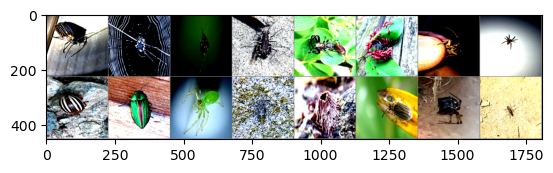

Prionoplus_reticularis Gasteracantha_cancriformis Verrucosa_arenata Cicindela_hirticollis Larinioides_cornutus Eriophyes_cerasicrumena Tetracha_carolina Zoropsis_spinimana Leptinotarsa_juncta Buprestis_aurulenta Lyssomanes_viridis Graphisurus_fasciatus Tetraclita_rubescens Ophraella_communa Parasteatoda_tepidariorum Cicindela_aurulenta


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = [class_name.split('_')[-2]+'_'+class_name.split('_')[-1] 
           for class_name in natsort.natsorted(os.listdir('data/2021_train_mini'))[:300]]

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## GoogLeNet 구현

In [8]:
class GoogLeNet(nn.Module):
    def __init__(self,aux_logits=True, num_classes=10, init_weights=True):
        super(GoogLeNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

        # conv_block takes in_channels, out_channels, kernel_size, stride, padding
        # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, 2, 1)
        self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, 2, 1)
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, 2, 1)
        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)

        # auxiliary classifier

        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)

        # auxiliary classifier

        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, 2, 1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(7, 1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)
        """
        aux_logits은 layer가 깊어질수록 기울기 소실 문제가 생겨 중간 중간마다 역전파 하기 위해 존재
        """
        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        else:
            self.aux1 = self.aux2 = None

        # weight initialization
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
     
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)

        x = x.view(x.shape[0], -1)

        x = self.dropout(x)
        x = self.fc1(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x 

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

## conv layer 구현: Conv -> BN -> 활성화 함수

In [9]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.conv_layer(x)

## Inception_block 구현 1x1 + 3x3 + 5x5 + pool 연결 연결전 1x1 conv로 features Depth를 줄임

In [10]:
class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
        
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size=1),
            conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

    def forward(self, x):
        # 0차원은 batch이므로 1차원인 filter 수를 기준으로 각 branch의 출력값을 묶어줍니다. 
        x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
        return x

# 레이어 중간마다 오차 측정을 하기 위해 보조 분류기 구현

In [11]:
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()

        self.conv = nn.Sequential(
            nn.AvgPool2d(kernel_size=5, stride=3),
            conv_block(in_channels, 128, kernel_size=1),
        )

        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self,x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

## 모델 학습

In [12]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GoogLeNet(num_classes=300).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 30
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [14]:
def train(loader, model,optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.train()
    for i, data in enumerate(tqdm(loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        output, aux1, aux2 = outputs
        """
        GoogLeNet의 경우 기울기 소실 문제를 해결하기 위해 보조 분류기의 loss에 0.3을 곱해서 더해줌
        """
        aux1_loss = criterion(aux1, labels)
        aux2_loss = criterion(aux2, labels)
        output_loss  = criterion(output, labels)
        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        _, predicted = output.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [15]:
def validation(loader, model, optimizer, criterion):
    running_loss = 0.0
    
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()



            # print statistics
            running_loss += loss.item()
    epoch_loss = running_loss /len(loader)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [16]:

for epoch in range(epochs):  # loop over the dataset multiple times
    best_acc = 0

    train_loss, train_acc = train(trainloader,model, optimizer, criterion)
    val_loss, val_acc = validation(testloader,model, optimizer, criterion)
    scheduler.step()
    is_best = val_acc > best_acc
    best_acc1 = max(val_acc, best_acc)
    
    
    save_checkpoint({
            'epoch': epoch + 1,

            'state_dict': model.state_dict(),
            'best_acc1': best_acc,
            'optimizer' : optimizer.state_dict(),
            'scheduler' : scheduler.state_dict()
        }, is_best)
        
    print(f'[{epoch}], train_loss:{train_loss:.4f}, val_loss:{val_loss:.4f}, train_acc:{train_acc*100:.4f}, val_acc:{val_acc*100:.4f}')
       
   
        
       


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.43it/s]


[0], train_loss:9.0045, val_loss:5.4491, train_acc:1.0333, val_acc:1.4333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.71it/s]


[1], train_loss:8.5491, val_loss:5.2180, train_acc:1.8067, val_acc:2.9333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.04it/s]


[2], train_loss:8.1872, val_loss:4.9596, train_acc:2.8267, val_acc:4.5000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.44it/s]


[3], train_loss:7.8545, val_loss:4.8827, train_acc:4.1867, val_acc:4.6333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.70it/s]


[4], train_loss:7.5575, val_loss:4.6369, train_acc:5.3333, val_acc:6.8000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.75it/s]


[5], train_loss:7.2574, val_loss:4.7119, train_acc:6.7200, val_acc:7.6333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.50it/s]


[6], train_loss:6.9891, val_loss:4.4357, train_acc:8.1867, val_acc:9.7667


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.31it/s]


[7], train_loss:6.7472, val_loss:4.4877, train_acc:10.1467, val_acc:9.0667


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.57it/s]


[8], train_loss:6.4925, val_loss:4.2160, train_acc:11.4933, val_acc:11.4333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.79it/s]


[9], train_loss:6.2525, val_loss:3.9619, train_acc:13.9600, val_acc:14.9667


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.83it/s]


[10], train_loss:5.5029, val_loss:3.6007, train_acc:20.6400, val_acc:20.6667


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.84it/s]


[11], train_loss:5.2452, val_loss:3.5796, train_acc:23.5667, val_acc:20.6000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.82it/s]


[12], train_loss:5.1521, val_loss:3.5849, train_acc:24.2600, val_acc:20.4333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.76it/s]


[13], train_loss:5.0358, val_loss:3.5412, train_acc:25.8400, val_acc:21.4333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.76it/s]


[14], train_loss:4.9597, val_loss:3.5370, train_acc:26.6400, val_acc:21.6333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.86it/s]


[15], train_loss:4.8559, val_loss:3.4840, train_acc:28.0933, val_acc:22.5333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.90it/s]


[16], train_loss:4.7811, val_loss:3.5026, train_acc:28.3333, val_acc:21.9333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.84it/s]


[17], train_loss:4.7026, val_loss:3.4593, train_acc:29.9400, val_acc:23.5000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.76it/s]


[18], train_loss:4.6068, val_loss:3.4782, train_acc:31.0067, val_acc:22.5333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.76it/s]


[19], train_loss:4.5337, val_loss:3.4715, train_acc:31.5267, val_acc:22.7333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.76it/s]


[20], train_loss:4.3387, val_loss:3.4085, train_acc:35.0600, val_acc:23.4000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.80it/s]


[21], train_loss:4.2728, val_loss:3.4106, train_acc:36.1733, val_acc:23.1333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.85it/s]


[22], train_loss:4.2434, val_loss:3.3851, train_acc:36.2600, val_acc:23.5000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.77it/s]


[23], train_loss:4.2246, val_loss:3.4051, train_acc:36.4800, val_acc:23.7000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.87it/s]


[24], train_loss:4.2339, val_loss:3.4000, train_acc:36.8867, val_acc:23.7000


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.83it/s]


[25], train_loss:4.2135, val_loss:3.3950, train_acc:36.7667, val_acc:23.9333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.85it/s]


[26], train_loss:4.2142, val_loss:3.3794, train_acc:36.7067, val_acc:23.5333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.77it/s]


[27], train_loss:4.1938, val_loss:3.3875, train_acc:37.4333, val_acc:24.2333


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.81it/s]


[28], train_loss:4.1603, val_loss:3.4014, train_acc:37.9133, val_acc:24.0667


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [00:08<00:00, 22.83it/s]

[29], train_loss:4.1685, val_loss:3.3877, train_acc:37.4200, val_acc:23.8333
